In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# pip install sewar
# !pip uninstall tensorflow
# !pip install tensorflow

In [ ]:
import numpy as np
import os
import random
import pandas as pd
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.losses
from sklearn.metrics import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# from sewar.full_ref import mse,psnr,msssim

In [ ]:
image_path = './drive/MyDrive/BS_JSRT/source'
target_path= './drive/MyDrive/BS_JSRT/target'

In [ ]:
image_list = os.listdir(image_path)
# image_list=image_list[:1000]
print(len(image_list))

4080


In [ ]:
def getData(shape):
    im_array = []
    target_array = []
    shape = (shape, shape)
    # shape = image_size
    for i in tqdm(image_list): 
      # im.shape = (shape, shape, 1)
      im = cv2.imread(os.path.join(image_path,i),cv2.IMREAD_GRAYSCALE)
      im = cv2.resize(im, shape)[:, :]
      im = im/255
      # target.shape = (shape, shape, 1)
      target = cv2.imread(os.path.join(target_path, i),cv2.IMREAD_GRAYSCALE)
      target = cv2.resize(target, shape)[:, :]
      target = target/255
      
      im_array.append(im)
      target_array.append(target)

    return im_array, target_array

In [ ]:
dim = 256
image_arr, target_arr = getData(dim)

100%|██████████| 4080/4080 [31:26<00:00,  2.16it/s]


In [ ]:
img_rows = 256
img_cols = 256
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)

image_arr= np.array(image_arr).reshape(-1, img_rows, img_cols, img_channels)
target_arr = np.array(target_arr).reshape(-1, img_rows, img_cols, img_channels)

# image_arr = np.array(image_arr).reshape(len(image_arr), dim, dim, 1)
# target_arr = np.array(target_arr).reshape(len(target_arr), dim, dim, 1)

Text(0.5, 1.0, 'target')

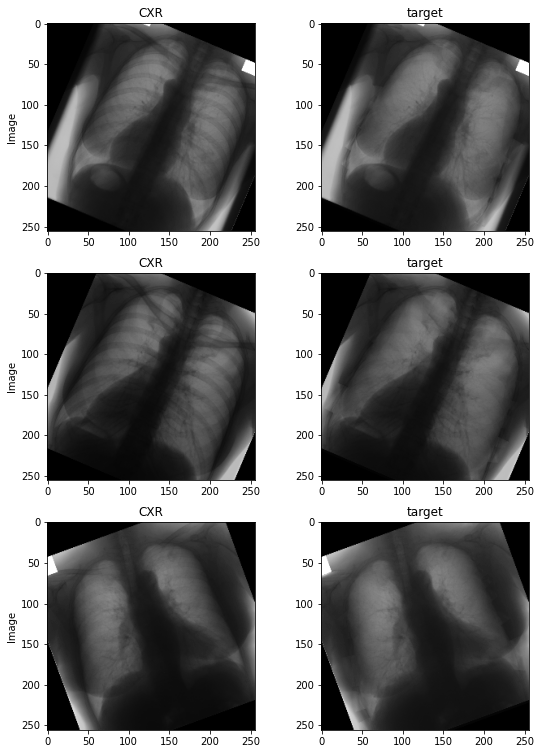

In [ ]:

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 13))
axs[0, 0].imshow(np.squeeze(image_arr[5]), cmap='gray')
axs[0, 1].imshow(np.squeeze(target_arr[5]), cmap='gray')
axs[0, 0].set_ylabel('Image')

axs[1, 0].imshow(np.squeeze(image_arr[25]), cmap='gray')
axs[1, 1].imshow(np.squeeze(target_arr[25]), cmap='gray')
axs[1, 0].set_ylabel('Image')

axs[2, 0].imshow(np.squeeze(image_arr[150]), cmap='gray')
axs[2, 1].imshow(np.squeeze(target_arr[150]), cmap='gray')
axs[2, 0].set_ylabel('Image')

axs[0, 0].set_title('CXR')
axs[1, 0].set_title('CXR')
axs[2, 0].set_title('CXR')

axs[0, 1].set_title('target')
axs[1, 1].set_title('target')
axs[2,1].set_title('target')

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(image_arr,target_arr,                                                  
                                                  test_size = 0.2, 
                                                  random_state = 42)
X_val, X_test, Y_val,Y_test = train_test_split(X_val,Y_val, 
                                                  test_size = 0.1, 
                                                  random_state = 42)

In [ ]:
print(X_train.shape, X_val.shape,X_test.shape,Y_train.shape, Y_val.shape,Y_test.shape)

(3264, 256, 256, 1) (734, 256, 256, 1) (82, 256, 256, 1) (3264, 256, 256, 1) (734, 256, 256, 1) (82, 256, 256, 1)


## METRICS AND LOSSES

In [ ]:
def tf_log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 * tf_log10((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true)))) 

def mae(y_true, y_pred):
    return tf.keras.metrics.mean_absolute_error(y_true, y_pred)

def ssim(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def ssim_loss(y_true, y_pred):
    return 1-tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def ssim_multi(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, 1.0))

def ssim_multi_loss(y_true, y_pred):
    return 1-tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, 1.0))
        
def loss_mix_multi_084(y_true, y_pred):    
    return 0.16 * mae(y_true, y_pred) + \
            0.84 * (1-ssim_multi(y_true, y_pred))


# AE-BS Model

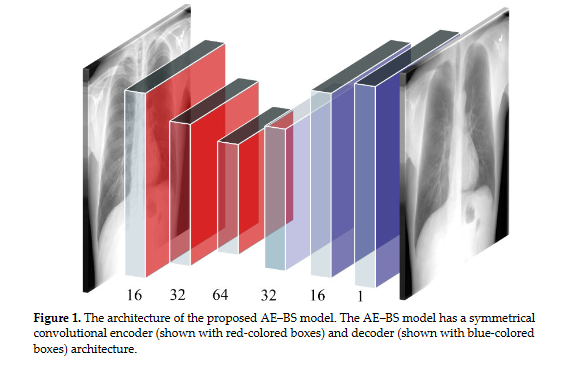

In [ ]:
def AE_BS(input_size=(256,256,1)):

  input = Input(input_size)

  #encoder
  conv1 = Conv2D(16, (5, 5), activation='relu', padding='same')(input) 
  conv2 = Conv2D(32, (5, 5), activation='relu', padding='same', strides=2)(conv1)
  conv3 = Conv2D(64, (5, 5), activation='relu', padding='same', strides=2)(conv2)
  #decoder
  conv4 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv3) 
  up1 = UpSampling2D((2,2))(conv4) 
  conv5 = Conv2D(16, (5, 5), activation='relu', padding='same')(up1)
  up2 = UpSampling2D((2,2))(conv5) 
  decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(up2) 

  return  Model(input, decoded)


In [ ]:
model = AE_BS(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=0.001), loss=loss_mix_multi_084, 
              metrics=[mae, ssim_multi_loss,
                       PSNR, ssim, ssim_multi])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        51232     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 16)      12816 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
weight_path="{}_weights.best.hdf5".format('BS_AE')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', 
                             verbose=1, save_weights_only=True,
                             save_best_only=True, mode='min') 
earlyStopping = EarlyStopping(monitor='val_loss', 
                               patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                              verbose=1, mode='min', min_lr=0.00001)
callbacks_list = [checkpoint, earlyStopping, reduce_lr]

In [ ]:
h = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=8, epochs=200,
                callbacks= callbacks_list)

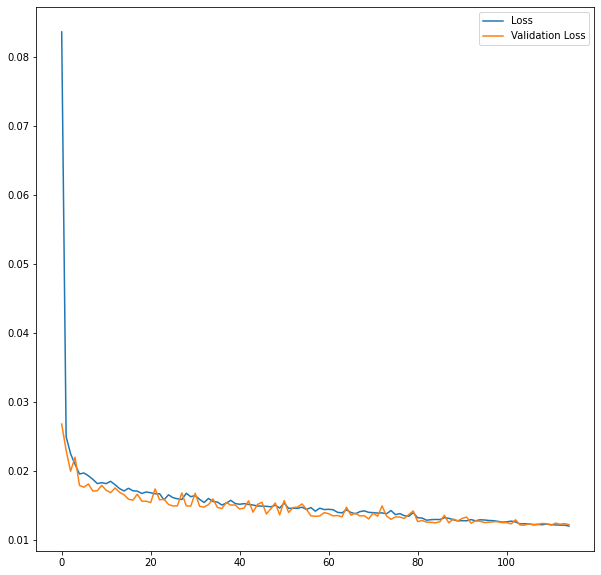

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize = (10, 10))
ax1.plot(h.history['loss'], '-', label = 'Loss')
ax1.plot(h.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

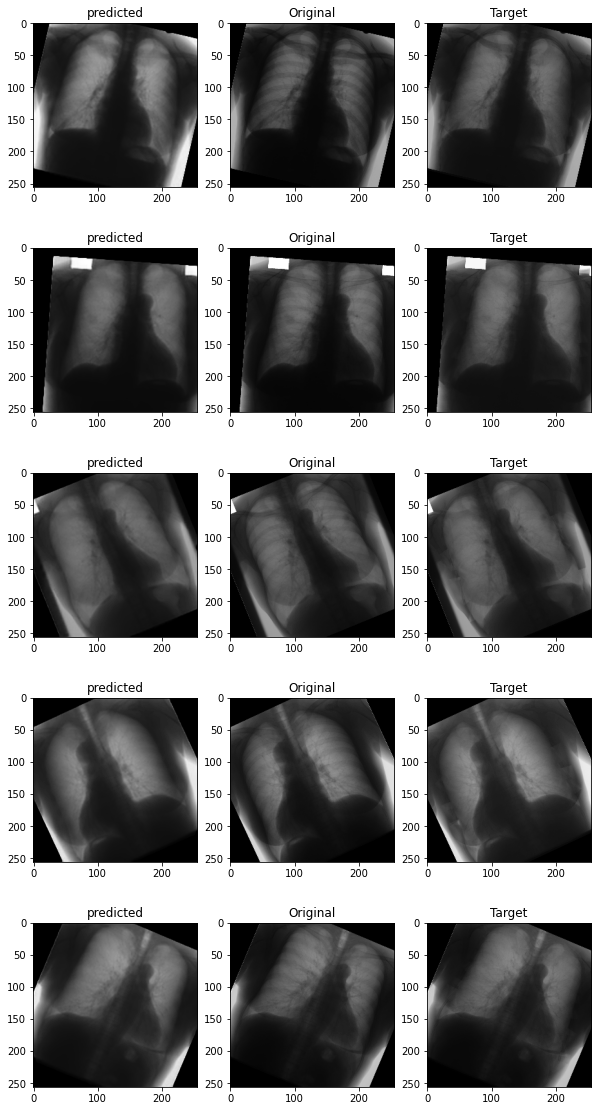

In [ ]:
preds = model.predict(X_test)

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for i in range(5):
    for j in range(3):
        if j == 1:
            axs[i, j].imshow(np.squeeze(X_test[i]), cmap='gray')
            axs[i, j].set_title('Original')
        elif j==2:
            axs[i, j].imshow(np.squeeze(Y_test[i]), cmap='gray')
            axs[i, j].set_title('Target')
        else:
            axs[i, j].imshow(np.squeeze(preds[i]), cmap='gray')
            axs[i, j].set_title('predicted')

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/BS_AE_weights.best.hdf5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        51232     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 16)      12816 

In [ ]:
test_path = '/content/drive/MyDrive/BS_JSRT/opacity effusion test images'
test_list = os.listdir(test_path)
shape = (512,512)
test_array = []

for i in test_list:
  im = cv2.imread(os.path.join(test_path,i),cv2.IMREAD_GRAYSCALE)
  im = cv2.resize(im, shape)[:, :]
  im = im/255

  test_array.append(im)

img_rows = 512
img_cols = 512
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)


test_array= np.array(test_array).reshape(-1, img_rows, img_cols, img_channels)

In [ ]:
preds = model.predict(test_array)


In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for i in range(4):
    for j in range(2):
        if j == 1:
            axs[i, j].imshow(np.squeeze(test_array[i]), cmap='gray')
            axs[i, j].set_title('Original')
        else:
            axs[i, j].imshow(np.squeeze(preds[i]), cmap='gray')
            axs[i, j].set_title('predicted')

# ResNet–BS

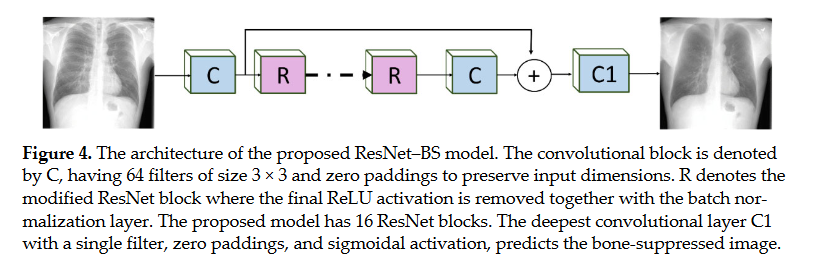

In [ ]:
#ResNet-BS model:

def resnet_bs(num_filters=64, num_res_blocks=16, res_block_scaling=None):
    x_in = Input(shape=(256,256,1))
    x = b = Conv2D(num_filters, (3, 3), padding='same')(x_in)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, (3, 3), padding='same')(b)
    x = Add()([x, b])
    x = Conv2D(1, (3, 3), padding='same')(x)
    return Model(x_in, x, name="ResNet-BS")

def res_block(x_in, filters, scaling):
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x_in)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x

resnet_bs = resnet_bs(num_filters=64, num_res_blocks=16, res_block_scaling=0.1)
resnet_bs.summary()

Model: "ResNet-BS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_7[0][0]                   
__________________________________________________________________________________________

In [ ]:
weight_path="{}_weights.best.hdf5".format('BS_ResNet')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', 
                             verbose=1, save_weights_only=True,
                             save_best_only=True, mode='min') 
earlyStopping = EarlyStopping(monitor='val_loss', 
                               patience=10, verbose=1, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                              verbose=1, mode='min', min_lr=0.00001)
callbacks_list = [checkpoint, earlyStopping, reduce_lr]

In [ ]:
resnet_bs.compile(optimizer=Adam(lr=0.001), loss=loss_mix_multi_084, 
              metrics=[mae, ssim_multi_loss,
                       PSNR, ssim, ssim_multi]) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
h = resnet_bs.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=8, epochs=200,
                callbacks= callbacks_list)

In [ ]:
resnet_bs.load_weights('/content/drive/MyDrive/Colab Notebooks/BS_ResNet_weights.best.hdf5')
resnet_bs.summary()

Model: "ResNet-BS"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_7[0][0]                   
__________________________________________________________________________________________

In [ ]:
from PIL import Image
import imageio
from keras.preprocessing import image
im = cv2.imread(os.path.join(test_path,i),cv2.IMREAD_GRAYSCALE)
im = cv2.resize(im, shape)[:, :]
im = im/255


pred = resnet_bs.predict(im)

In [ ]:
preds = resnet_bs.predict((test_arr))

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for i in range(4):
    for j in range(2):
        if j == 1:
            axs[i, j].imshow(np.squeeze(test_array[i]), cmap='gray')
            axs[i, j].set_title('Original')
        else:
            axs[i, j].imshow(np.squeeze(preds[i]), cmap='gray')
            axs[i, j].set_title('predicted')